In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk
import random

In [18]:
# import the image
im1 = cv2.imread('img/im01.jpg', cv2.IMREAD_COLOR)
im2 = cv2.imread('img/im02.jpg', cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [19]:
# show input image
input_images = np.hstack((im1, im2))
# while True:
#     cv2.imshow('Input Images',input_images)
#     if cv2.waitKey(1) == ord('q'):
#         break
#     # Release everything if job is finished
# cv2.destroyAllWindows()
# show input image
cv2.imshow('Two imgs', input_images)
cv2.waitKey(0)
cv2.destroyWindow('Two imgs')
cv2.waitKey(1)

-1

In [20]:
# mini square
def mini_square(des1, des2):
    [p1, n] = des1.shape
    [p2, n] = des2.shape

    # find mini distance position
    # return the matches relationship of both sides
    matches1 = []
    for j in range(0, p1):
        dis = np.zeros([p2, 1])
        for k in range(0, p2):
            v = des1[j] - des2[k]
            dis[k] = np.dot(v, v.T)

        # find the mini position
        pos = np.argmin(dis)
        # _distance should not be float
        tmp = int(dis[pos])

        # store the position in DMatch
        matches1.append(cv2.DMatch(_distance=tmp, _queryIdx=j, _trainIdx=pos, _imgIdx=0))

    matches2 = []
    for j in range(0, p2):
        dis = np.zeros([p1, 1])
        for k in range(0, p1):
            v = des2[j] - des1[k]
            dis[k] = np.dot(v, v.T)

        # find the mini position
        pos = np.argmin(dis)
        tmp = int(dis[pos])

        # store the position in DMatch
        matches2.append(cv2.DMatch(_distance=tmp, _queryIdx=j, _trainIdx=pos, _imgIdx=0))

    # matches points that are same in query index and train index
    matches = []
    for i in matches1:
        for j in matches2:
            if i.queryIdx == j.trainIdx and i.trainIdx == j.queryIdx:
                matches.append(i)

    return matches


In [21]:
# Find SIFT and return Homography Matrix
def SIFT(im1, im2):
    # im1 and im2 are grayscale image

    # Initialize SIFT 
    sift = cv2.SIFT_create()

    # turn to grayscale
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Extract keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)

    # match the points
    # using DMatch instead of matrix. matrix not so powerful and easily went wrong
    matches = mini_square(des1, des2)

    #     # Bruteforce matcher on the descriptors
    #         another way to match the pairs of points using KNN

    #     bruteforce=cv2.BFMatcher()
    #     matches=bruteforce.knnMatch(des1,des2, k=2)

    #     # Make sure that the matches are good
    #     verify_ratio=0.8 
    #     verified_matches=[]
    #     for m1,m2 in matches:
    #         # Add to array only if it's a good match
    #         if m1.distance<0.8*m2.distance:
    #             #turn DMatch to matrix
    #             verified_matches.append([m1.queryIdx,m1.trainIdx])

    #     verified_matches = np.matrix(verified_matches)

    # Mimnum number of matches
    min_matches = 8
    if len(matches) > min_matches:
        return matches, kp1, kp2
    else:
        print('Error: Not enough matches')
        exit()

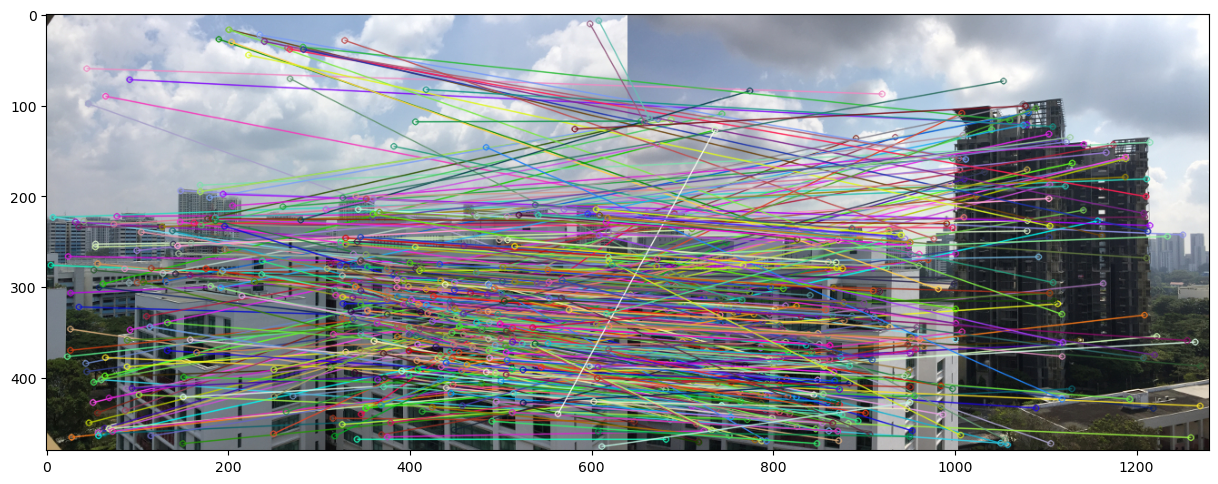

In [22]:
# method 1
# plot matching line
# Use SIFT to find keypoints and match the keypoints
[kpm, kp1, kp2] = SIFT(im1, im2)
match_res = cv2.drawMatches(img1, kp1, img2, kp2, kpm, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 15))
plt.imshow(match_res)
plt.show()

In [23]:
# method 2
# plot matching line
mat_images = np.hstack((im1, im2))
line_num = len(kpm)
_, y_com, _ = im1.shape

line_size = 1
thickness = 1  #  0, 2, 4, 8

# draw lines between matching pairs of points
for index in kpm:
    # random color
    bgr = np.random.randint(0, 255, 3, dtype=np.int32)

    # ps-the start of the line
    # pe-the end of the line
    ps = int(index.queryIdx)
    pe = int(index.trainIdx)

    # draw line
    cv2.line(mat_images, [int(kp1[ps].pt[0]), int(kp1[ps].pt[1])],
             [int(kp2[pe].pt[0] + y_com), int(kp2[pe].pt[1])], (int(bgr[0]), int(bgr[1]), int(bgr[2])), thickness)

# show the matching points
cv2.imshow('Matches points Images', mat_images)
cv2.waitKey(0)
cv2.destroyWindow('Matches points Images')
cv2.waitKey(1)

-1

In [24]:
# homography computing
def hmat(points):
    row = len(points)
    n_mat = int(row / 2)
    A = np.zeros([row, 9])

    for i in range(0, n_mat):
        h1_x = points[i][0]
        h1_y = points[i][1]
        h2_x = points[i + n_mat][0]
        h2_y = points[i + n_mat][1]
        A[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        A[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]

    _, _, vt = linalg.svd(A)
    H = vt[-1].reshape(3, 3)
    H = H / H[2, 2]  # H(3,3) = 1

    return H


# count inliers
def inlier(H, mp, matches, threshold):
    row = len(mp)
    p1 = mp[:, 0:2]
    p2 = mp[:, 2:4]

    x1 = np.concatenate((p1, np.ones([row, 1])), axis=1)
    # transfer 
    x2 = np.dot(H, x1.T)
    x2 = x2[0:2, :] / x2[2, :]
    es_p2 = x2[0:2, :].T

    # distance
    diff = p2 - es_p2
    sq = diff * diff
    dis = np.sqrt(sq[:, 0] + sq[:, 1])

    # calculate the number of points that distance < threshold
    # inliers' position
    match = []
    for i in range(0, row):
        if dis[i] < threshold:
            match.append(matches[i])

    return match


# find whether there is same value in a matrix
def judgequale(a):
    count = 0
    # sort the matrix by the 1st col
    a = np.sort(a)
    while True:
        if a[count, 0] == a[count + 1, 0]:
            return True
        elif count == len(a) - 2:
            return False
        else:
            count += 1


# RANSAC + Homography
def homo_ransac(kp1, kp2, matches, repeat):
    # n the pairs of keypoints selected randomly (n >= 4)
    n = 4
    # loop times
    loop = repeat
    # HH the largest inliers H
    HH = []
    # threshold of the inliers distance
    threshold = 1
    # inliers box
    num_in = 0

    # change the kp1 and kp2 from tuple to list
    N = len(matches)
    k1 = np.zeros([N, 2])
    k2 = np.zeros([N, 2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            k1[i, j] = kp1[matches[i].queryIdx].pt[j]
            k2[i, j] = kp2[matches[i].trainIdx].pt[j]

    # matched points
    mp = np.concatenate((k1, k2), axis=1)
    match_best = []

    for i in range(0, loop):
        # Use four random pair of keypoints to compute the homography matrix
        rdm = random.sample(range(0, N), 4)
        points = np.array([[k1[rdm[0]][0], k1[rdm[0]][1]], [k1[rdm[1]][0], k1[rdm[1]][1]],
                           [k1[rdm[2]][0], k1[rdm[2]][1]], [k1[rdm[3]][0], k1[rdm[3]][1]],
                           [k2[rdm[0]][0], k2[rdm[0]][1]], [k2[rdm[1]][0], k2[rdm[1]][1]],
                           [k2[rdm[2]][0], k2[rdm[2]][1]], [k2[rdm[3]][0], k2[rdm[3]][1]]])

        # compute H
        H = hmat(points)

        # count inliers
        match = inlier(H, mp, matches, threshold)

        # keep the max inliers parameter
        if len(match) > num_in:
            num_in = len(match)
            HH = H
            match_best = match

    return HH, match_best


# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH, match_best = homo_ransac(kp1, kp2, kpm, 100000)

    if len(match_best) > 0:
        break

/var/folders/zv/7_nb_lnx5llfxwncr2x_6tvh0000gn/T/ipykernel_10016/654497262.py:31: RuntimeWarning: divide by zero encountered in divide
  x2 = x2[0:2, :] / x2[2, :]


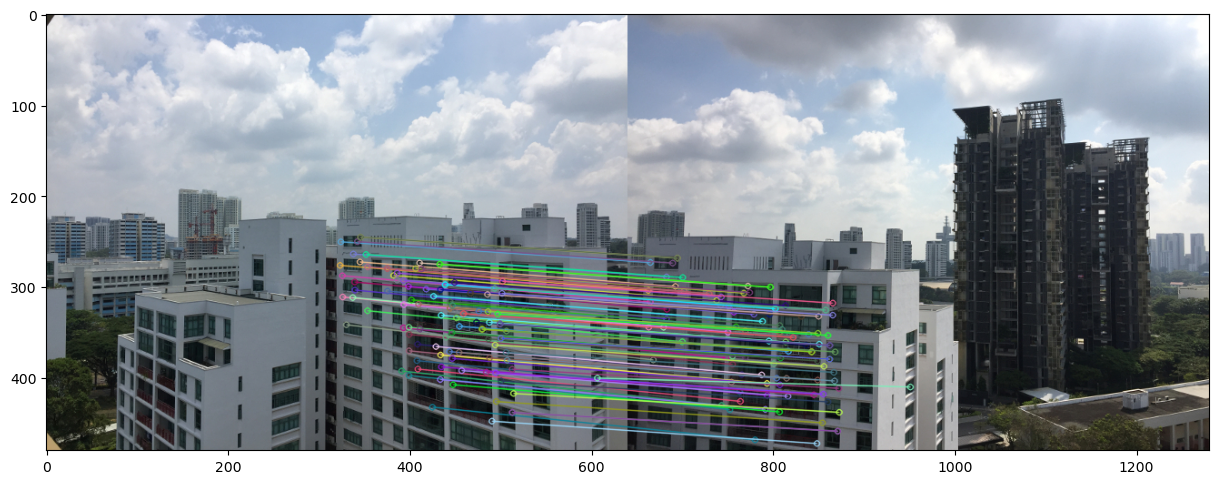

In [25]:
# method 1
# plot inliers matching line
match_bestres = cv2.drawMatches(img1, kp1, img2, kp2, match_best, None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 15))
plt.imshow(match_bestres)
plt.show()

In [26]:
# method 2 
# plot inliers matching line
in_images = np.hstack((im1, im2))
line_num = len(match_best)
x_com, y_com, _ = im1.shape

line_size = 1
thickness = 1

for index in match_best:
    # random color
    bgr = np.random.randint(0, 255, 3, dtype=np.int32)

    ps = int(index.queryIdx)
    pe = int(index.trainIdx)

    cv2.line(in_images, [int(kp1[ps].pt[0]), int(kp1[ps].pt[1])],
             [int(kp2[pe].pt[0] + y_com), int(kp2[pe].pt[1])], (int(bgr[0]), int(bgr[1]), int(bgr[2])), thickness)

# show the image
cv2.imshow('Inliers Images', in_images)
cv2.waitKey(0)
cv2.destroyWindow('Inliers Images')
cv2.waitKey(1)

-1

In [27]:
# recalculate H matrix with all inliers

# change the inliers from tuple to list
N = len(match_best)
in1 = np.zeros([N, 2])
in2 = np.zeros([N, 2])

# Get the coordinate of keypoint
for i in range(N):
    for j in range(2):
        in1[i] = [kp1[match_best[i].queryIdx].pt[1], kp1[match_best[i].queryIdx].pt[0]]
        in2[i] = [kp2[match_best[i].trainIdx].pt[1], kp2[match_best[i].trainIdx].pt[0]]

# compare the Homography compute from the random points and the inliers
in_points = np.concatenate((in1, in2), axis=0)
H_best = hmat(in_points)
print(H_best)
print(HH)

[[ 1.81529188e+00  5.36960120e-01 -1.98674642e+02]
 [-1.04341057e-01  2.22009682e+00 -6.54301599e+02]
 [-1.28859230e-04  1.86890873e-03  1.00000000e+00]]
[[ 2.25995959e+00 -1.09901843e-01 -6.65387275e+02]
 [ 5.65243806e-01  1.83194527e+00 -2.06567037e+02]
 [ 1.94584280e-03 -1.47312134e-04  1.00000000e+00]]


In [28]:
# transform h1 to h2
def get_size(h1, H):
    [row, col, c] = h1.shape

    # 4 cornor of the image h1
    lt = np.array([[0, 0, 1]])
    rt = np.array([[0, col, 1]])
    lb = np.array([[row, 0, 1]])
    rb = np.array([[row, col, 1]])

    # edge matrix
    edge = np.concatenate((lt, rt, lb, rb), axis=0).T

    T_edge = np.dot(H, edge)
    # normalize
    T_edge = T_edge[0:2, :] / T_edge[2, :]
    T_edge = T_edge

    return np.max(T_edge[0, :]), np.min(T_edge[0, :]), np.max(T_edge[1, :]), np.min(T_edge[1, :])


# build a canvas
def get_canvas(im1, im2, Hi):
    # Hi is im2 to im1
    [row1, col1, c] = im1.shape
    [row2, col2, c] = im2.shape

    # get the edge
    [x_max, x_min, y_max, y_min] = get_size(im2, Hi)
    print([x_min, x_max, y_min, y_max])
    x_minus = int(np.min([0, x_min]) - 10)
    x_plus = int(np.max([0, x_max - row1]) + 10)
    y_minus = int(np.min([0, y_min]) - 10)
    y_plus = int(np.max([0, y_max - col1]) + 10)

    # x direction adding space
    add_x_minus = np.zeros([-x_minus, col1, c])
    add_x_plus = np.zeros([x_plus, col1, c])

    # y direction adding space
    add_y_minus = np.zeros([-x_minus + row1 + x_plus, -y_minus, c])
    add_y_plus = np.zeros([-x_minus + row1 + x_plus, y_plus, c])

    # concatenate the adding space with im1
    canvas = np.concatenate((add_x_minus, im1, add_x_plus), axis=0)
    canvas = np.concatenate((add_y_minus, canvas, add_y_plus), axis=1)

    return canvas.astype(int), [x_minus, y_minus]



[-262.77557248759945, 606.5151362499903, 295.74981109639816, 1276.926628487416]
[-272, -10]


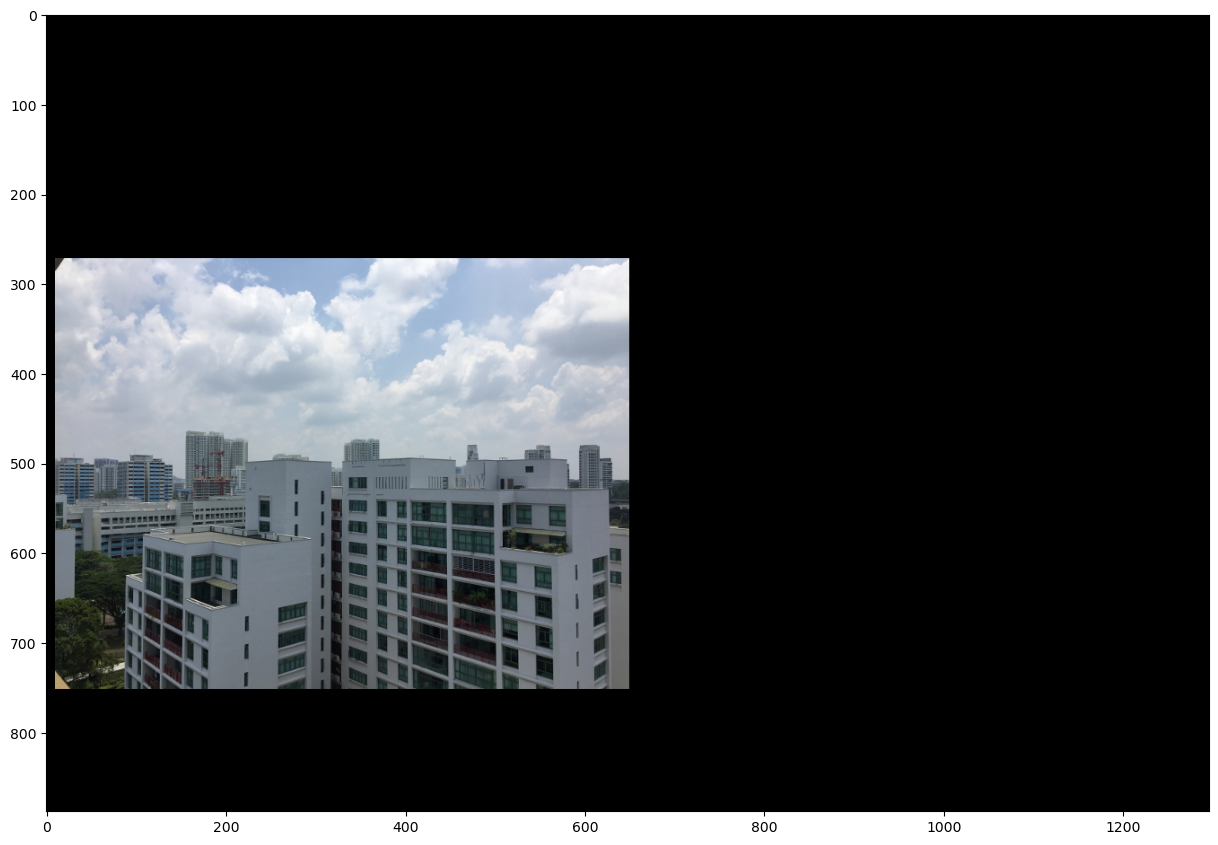

In [29]:
# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas, compensation = get_canvas(img1, img2, Hi)

# show the canvas
print(compensation)
plt.figure(figsize=(15, 15))
plt.imshow(canvas)

In [30]:
def trans2im1(canvas, im2, Hi, compensation):
    # the wight of the im1 when overlay
    w = 0.6

    # step of the transmitting 1/step
    step = 3
    [row, col, c] = im2.shape

    # draw im2 on the canvas
    for j in range(0, row * step):
        for k in range(0, col * step):
            # positon: points of im2 in im1 plane 
            p = np.array([[j / step, k / step, 1]]).T
            Tp = np.dot(Hi, p)

            # normalize and move the image
            x2 = int(round(Tp[0, 0] / Tp[2, 0]) - compensation[0])
            y2 = int(round(Tp[1, 0] / Tp[2, 0]) - compensation[1])

            # position in im1
            x1 = int(j / step)
            y1 = int(k / step)

            if np.any(canvas[x2, y2] > 0):
                canvas[x2, y2] = w * canvas[x2, y2][:] + (1 - w) * im2[x1, y1][:]
            else:
                canvas[x2, y2] = im2[x1, y1][:]

    return canvas.astype(int)


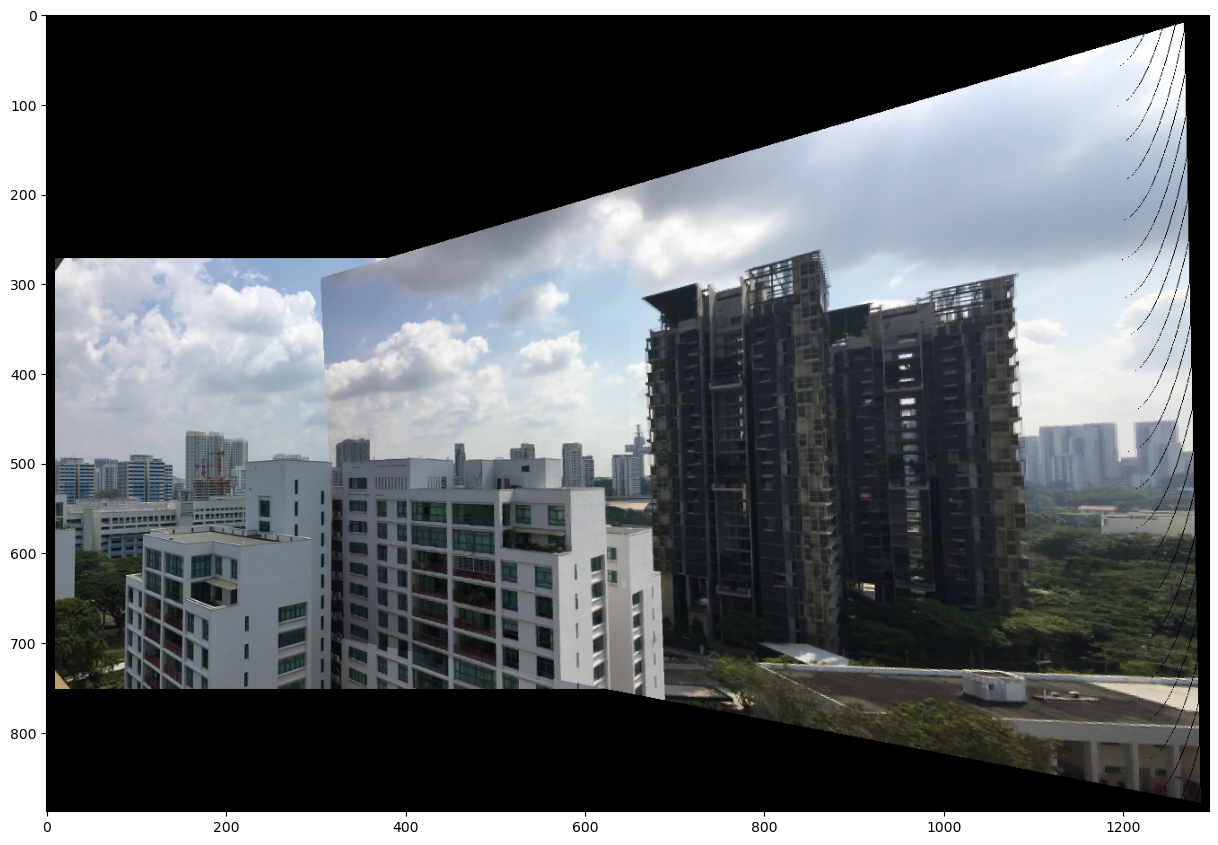

In [31]:
# transfer im2 to im1 plane
Tim1 = trans2im1(canvas, img2, Hi, compensation)
# show the sitching image
plt.figure(figsize=(15, 15))
plt.imshow(Tim1)